# Build Average Face

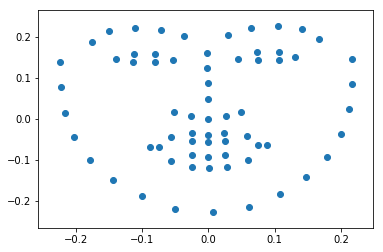

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

faces_path = "300w/"
image_files = []
pts_files = []
for file in os.listdir(faces_path):
    if file.endswith(".png"):
        image_files.append(file)
#         print(file)
    elif file.endswith(".pts"):
        pts_files.append(file)

image_files.sort()
pts_files.sort()


# Get Landmark X and Y Points
landmark_x = []
landmark_y = []
for pts in pts_files:
    pts_path = faces_path + pts
    with open(pts_path) as pts_file:
        data = pts_file.readlines()[3:68+3]
        data = [np.array(line.split(), dtype=float) for line in data]
        landmarks = np.array(data)

        x_points = landmarks[:,0]
        y_points = landmarks[:,1]
        
        landmark_x.append(x_points)
        landmark_y.append(y_points)

landmark_x = np.array(landmark_x)
landmark_y = np.array(landmark_y)


# Get image dimensions for normalization
im_rows = []
im_cols = []
for image in image_files:
    im = cv2.imread(faces_path + image)
    im_rows.append(im.shape[0])
    im_cols.append(im.shape[1])

im_rows = np.array(im_rows)
im_cols = np.array(im_cols)

# Normalize by dividing by image height and width
for i in range(600):
    landmark_x[i] /= im_cols[i]
    landmark_y[i] /= im_rows[i]

    # center on landmark 34 (tip of nose)
    landmark_x[i] -= landmark_x[i,33]
    landmark_y[i] -= landmark_y[i,33]
    
# Compute average face
average_x = np.mean(landmark_x, axis=0)
average_y = np.mean(landmark_y, axis=0)

plt.figure(0)
plt.scatter(average_x, -1 * average_y)
plt.show()

# Compute Facial Models

In [2]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

artist_path = "AF_dataset/Utagawa_Kunisada/"
image_files = []
json_files = []
for file in os.listdir(artist_path):
    if file.endswith(".png"):
        image_files.append(file)
    elif file.endswith(".ljson"):
        json_files.append(file)
        
image_files.sort()
json_files.sort()
assert(len(image_files) == len(json_files))
n = len(image_files)
n_landmarks = 68

print(image_files)
print(json_files)
print(n)

['50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png']
['50.ljson', '51.ljson', '52.ljson', '53.ljson', '54.ljson', '55.ljson', '56.ljson', '57.ljson', '58.ljson', '59.ljson']
10


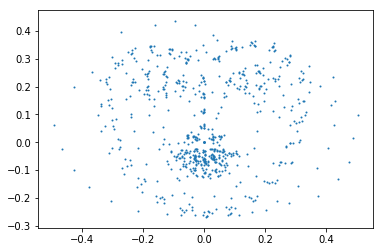

In [3]:
# Build data matrices for x and y landmark points
x_data = np.zeros((n,n_landmarks))
y_data = np.zeros((n, n_landmarks))
i = 0
for json_name in json_files:
    with open(artist_path + json_name) as json_file:
        landmarks = json.load(json_file)
    points = np.array(landmarks["landmarks"]["points"]) # 68 x 2 np array
    x_data[i] = points[:,1]
    y_data[i] = points[:,0]
    i += 1
# print(x_data.shape)
# print(y_data.shape)

# Get image dimensions for normalization
im_rows = []
im_cols = []
for image in image_files:
    im = cv2.imread(artist_path + image)
    im_rows.append(im.shape[0])
    im_cols.append(im.shape[1])
    
# normalize
for i in range(n):
    x_data[i] /= im_cols[i]
    y_data[i] /= im_rows[i]
    
    # center on landmark 34 (tip of nose)
    x_data[i] -= x_data[i,33]
    y_data[i] -= y_data[i,33]
    
plt.figure(1)
plt.scatter(x_data, -1 * y_data, s=1)
plt.show()

In [4]:
# compute difference vectors
x_diff = x_data - average_x # 10 x 68
y_diff = y_data - average_y # 10 x 68

v_artist = np.concatenate((x_diff, y_diff), axis=1) # first 68 are x and last 68 are y in each row
# print(v_artist.shape)

# compute statistics
mu_artist = np.mean(v_artist, axis=0)
cov_artist = np.cov(v_artist.T)

# save model
mean_path = artist_path + "mean"
cov_path = artist_path + "cov"
np.save(mean_path, mu_artist)
np.save(cov_path, cov_artist)